In [1]:
from google.colab import drive
import pandas as pd

In [2]:
drive.mount('/content/drive')
user_data = pd.read_csv('/content/drive/MyDrive/machine-learning-project/users_export.csv')
movie_data = pd.read_csv('/content/drive/MyDrive/machine-learning-project/movie_data.csv', lineterminator='\n')
rate_data = pd.read_csv('/content/drive/MyDrive/machine-learning-project/ratings_export.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Tratando os dados

##### Removendo as colunas que não serão necessárias

In [3]:
user_data.drop(['_id', 'display_name', 'num_ratings_pages'], axis= 1, inplace= True)

In [4]:
rate_data.drop('_id', axis= 1, inplace= True)

In [5]:
movie_data.drop(['_id',
 'image_url',
 'imdb_id',
 'imdb_link',
 'overview',
 'movie_title',
 'original_language',
 'release_date',
 'spoken_languages',
 'tmdb_id',
 'tmdb_link'], axis= 1, inplace=True)

### Tratando tabela de usuários

In [6]:
user_data.rename(columns={'username': 'user_id'}, inplace= True) # Renomeando coluna para facilitar o merge

In [7]:
# Verificando se há valores null
user_data.isnull().sum()

num_reviews    0
user_id        0
dtype: int64

In [8]:
# Verificando se os usuários não possuem reviews e removendo-os
print((user_data['num_reviews'] == 0).sum())
user_data.drop(user_data[user_data.num_reviews == 0].index, inplace= True)

78


### Tratando tabela de avaliações

In [9]:
rate_data.head()

,movie_id,rating_val,user_id
0,feast-2014,7,deathproof
1,loving-2016,7,deathproof
2,scripted-content,7,deathproof
3,the-future,4,deathproof
4,mank,5,deathproof


In [10]:
# Verificando e removendo valores null
print(rate_data.isnull().sum())
rate_data.drop(rate_data[rate_data.movie_id.isnull()].index, inplace = True)

movie_id      6
rating_val    0
user_id       0
dtype: int64


In [11]:
rate_data.shape

(11078161, 3)

### Tratando tabela filmes

In [12]:
movie_data.head()

,genres,movie_id,popularity,production_countries,runtime,vote_average,vote_count,year_released
0,"[""Music"",""Animation""]",football-freaks,0.600,"[""United Kingdom""]",0.0,0.0,0.0,1971.0
1,[],aftermath-1960,0.600,[],22.0,8.0,1.0,1960.0
2,"[""Drama""]",where-chimneys-are-seen,1.568,"[""Japan""]",108.0,6.6,10.0,1953.0
3,"[""Drama""]",the-musicians-daughter,0.600,"[""United States of America""]",15.0,0.0,0.0,1911.0
4,"[""Documentary""]",50-years-of-fabulous,0.600,[],75.0,0.0,0.0,2018.0


In [13]:
# Verificando os valores nulos
movie_data.isnull().sum()

genres                  10632
movie_id                    2
popularity              10632
production_countries    10632
runtime                 15449
vote_average            10632
vote_count              10632
year_released            7572
dtype: int64

In [14]:
# Removendo os filmes que possuem valores nulos
movie_data.drop(movie_data[movie_data.genres.isnull()].index, inplace=True)
movie_data.drop(movie_data[movie_data.runtime.isnull()].index, inplace=True)
movie_data.drop(movie_data[movie_data.year_released.isnull()].index, inplace=True)

In [15]:
# definindo apenas os filmes com +60 min de duração, mais de 1000 reviews
movie_data.drop(movie_data[movie_data.runtime < 60].index, inplace=True)
movie_data.drop(movie_data[movie_data.vote_count < 1000].index, inplace=True)

### Merge

In [16]:
merge_user_rate = pd.merge(user_data, rate_data, on= 'user_id', how= 'inner')

In [17]:
merge_user_rate_movie = pd.merge(merge_user_rate, movie_data, on= 'movie_id', how= 'inner')

In [18]:
main_df = merge_user_rate_movie

## Analisando o conjunto de dados

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [20]:
main_df.columns.tolist()

['num_reviews',
 'user_id',
 'movie_id',
 'rating_val',
 'genres',
 'popularity',
 'production_countries',
 'runtime',
 'vote_average',
 'vote_count',
 'year_released']

In [21]:
df = pd.DataFrame(columns = ['filme', 'genero', 'pais_producao', 'popularidade', 'duracao', 'media_avaliacao', 'ano_lancamento', 'nota_usuario'])
df.filme = np.array(main_df.movie_id)
df.genero = np.array(main_df.genres)
df.pais_producao = np.array(main_df.production_countries)
df.popularidade = np.array(main_df.popularity)
df.duracao = np.array(main_df.runtime)
df.media_avaliacao = np.array(main_df.vote_average)
df.ano_lancamento = np.array(main_df.year_released)
df.nota_usuario = np.array(main_df.rating_val)

In [22]:
def classificar_nota(nota):
  if nota >= 7:
    return 1  # Se a nota de avalição do usuário for maior ou igual a 7, consideramos que ele gostou desse filme
  else:
    return 0  # Se a nota de avalição do usuário for menor 7, consideramos que ele não gostou desse filme
df['recomendacao'] = df['nota_usuario'].apply(classificar_nota)
print(df)

                                       filme  \
0                                       mank   
1                                       mank   
2                                       mank   
3                                       mank   
4                                       mank   
...                                      ...   
4801611                     gabriels-inferno   
4801612                     gabriels-inferno   
4801613             gabriels-inferno-part-ii   
4801614     night-on-bald-mountain-ave-maria   
4801615  batman-vs-superman-ultimate-edition   

                                   genero                 pais_producao  \
0                     ["Drama","History"]  ["United States of America"]   
1                     ["Drama","History"]  ["United States of America"]   
2                     ["Drama","History"]  ["United States of America"]   
3                     ["Drama","History"]  ["United States of America"]   
4                     ["Drama","History"]  ["Uni

In [23]:
# enumerando colunas
from sklearn.preprocessing import LabelEncoder

In [24]:
enumerador = LabelEncoder()

df['genero'] = enumerador.fit_transform(df['genero'])
df['filme'] = enumerador.fit_transform(df['filme'])
df['pais_producao'] = enumerador.fit_transform(df['pais_producao'])

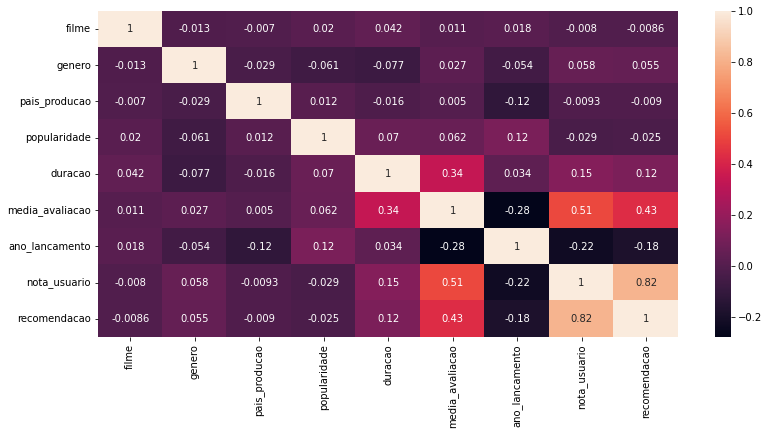

In [25]:
# correlação
amostra = df.sample(frac = 0.6)
correlacao = amostra.corr()
correlacao_graf = sns.heatmap(correlacao, annot= True)
correlacao_graf.figure.set_size_inches(13,6)

In [27]:
amostra = df.sample(frac = 0.60)
model = DecisionTreeClassifier()

In [28]:
X = amostra[['filme','genero','popularidade','pais_producao', 'media_avaliacao', 'ano_lancamento']]
y = amostra['recomendacao']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
y_pred = model.predict(X_test)

In [33]:
accuracy = accuracy_score(y_test, y_pred)

print(f'Precisão: {accuracy:.2f}')

Precisão: 0.75


In [34]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69    253511
           1       0.75      0.82      0.79    322683

    accuracy                           0.75    576194
   macro avg       0.75      0.74      0.74    576194
weighted avg       0.75      0.75      0.75    576194



In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
from sklearn.utils.extmath import randomized_range_finder
RandomForestClassifier(random_state = 42)

RandomForestClassifier(random_state=42)

In [37]:
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
predictions_train = model.predict(X_train)
accuracy = metrics.accuracy_score(y_train, predictions_train)
print('Accuracy:%.4f' %accuracy)

Accuracy:0.7493


In [39]:
predictions_test = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predictions_test)
print('Accuracy:%.4f' %accuracy)

Accuracy:0.7478


In [40]:
print(metrics.classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69    253511
           1       0.75      0.82      0.79    322683

    accuracy                           0.75    576194
   macro avg       0.75      0.74      0.74    576194
weighted avg       0.75      0.75      0.75    576194

